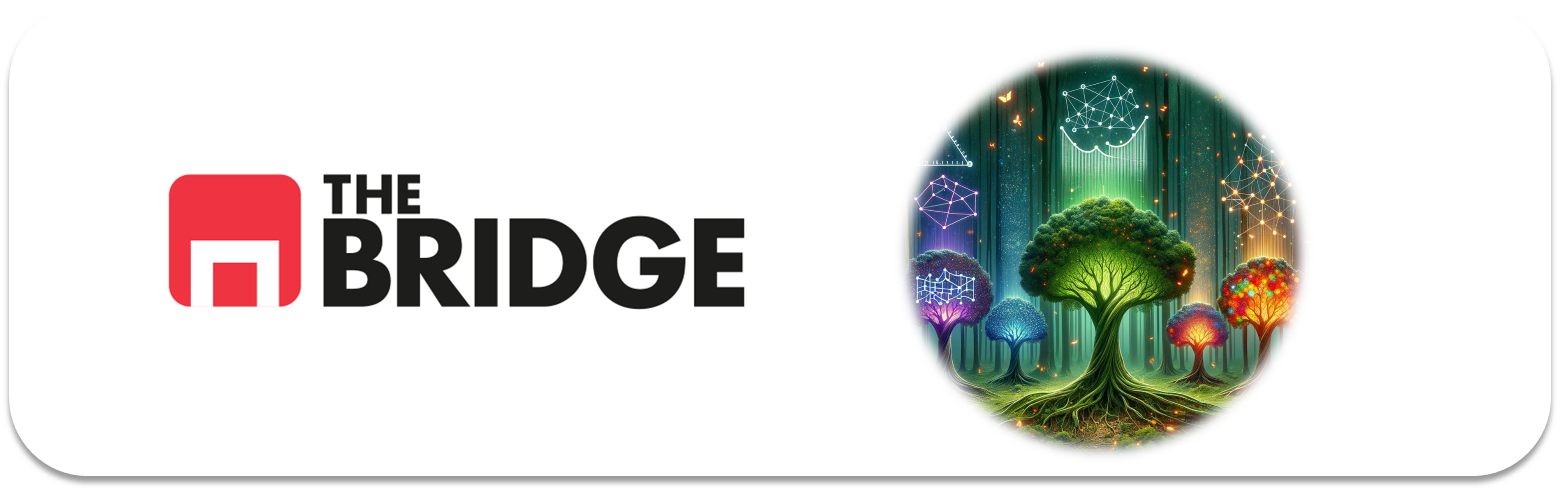

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [115]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

In [98]:
df = pd.read_csv('./data/bank-full.csv', sep=";")

In [99]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [101]:
target= 'y'

for col in df.columns:
    values = df[col].value_counts()
    if "unknown" in values:
        nsnr=values["unknown"]
        print(f"En la columna {col} son desconocidos {nsnr} valores")

En la columna job son desconocidos 288 valores
En la columna education son desconocidos 1857 valores
En la columna contact son desconocidos 13020 valores
En la columna poutcome son desconocidos 36959 valores


In [102]:
df.poutcome.value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

Con la columna poutcome tendremos problemas, ya que la mayoria de los valores son desconocidos.

In [103]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [104]:
print(train_set.y.value_counts(normalize= True))
print(test_set.y.value_counts(normalize= True))

y
no     0.883931
yes    0.116069
Name: proportion, dtype: float64
y
no     0.879354
yes    0.120646
Name: proportion, dtype: float64


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [106]:
categoricas = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numericas = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

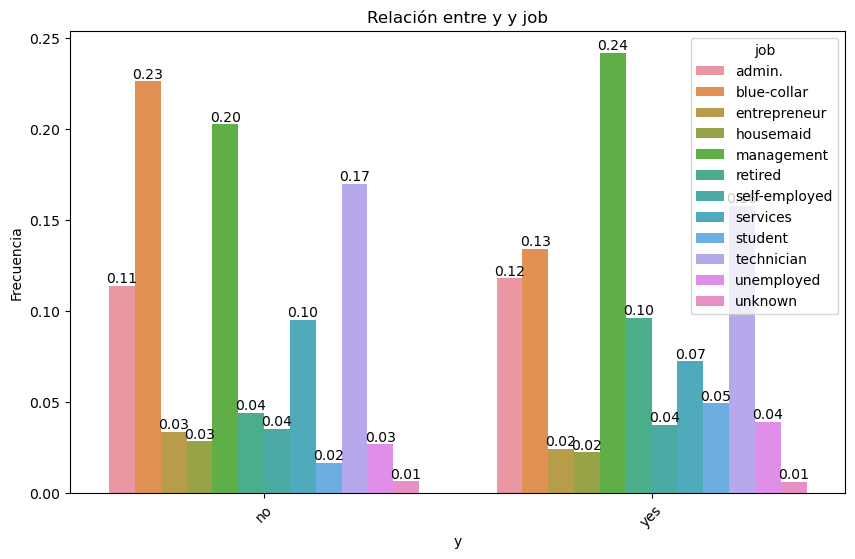

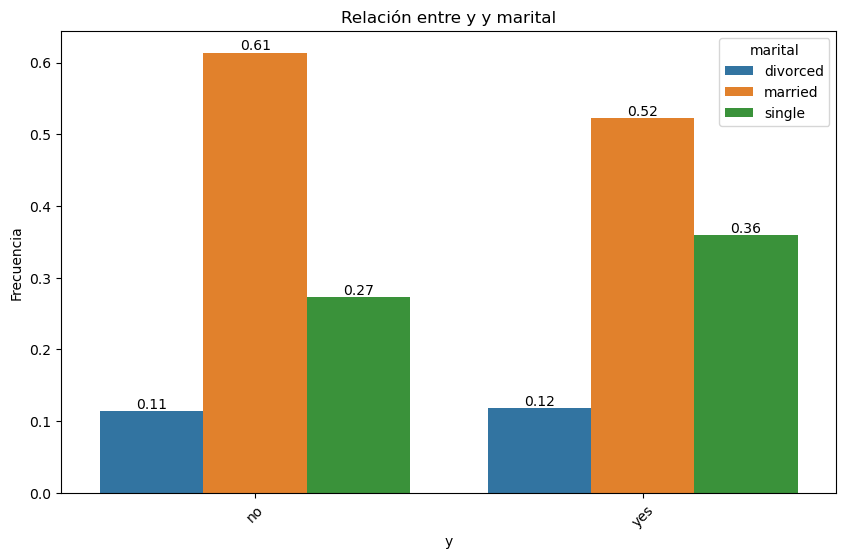

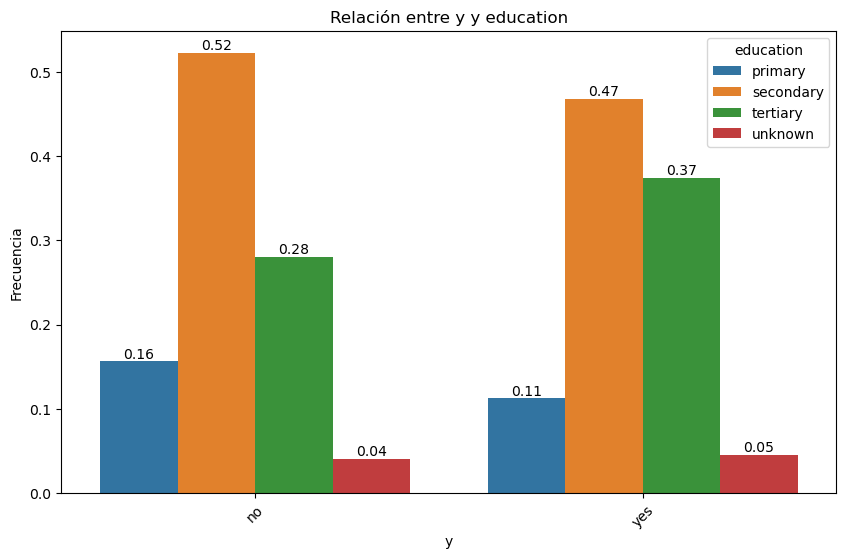

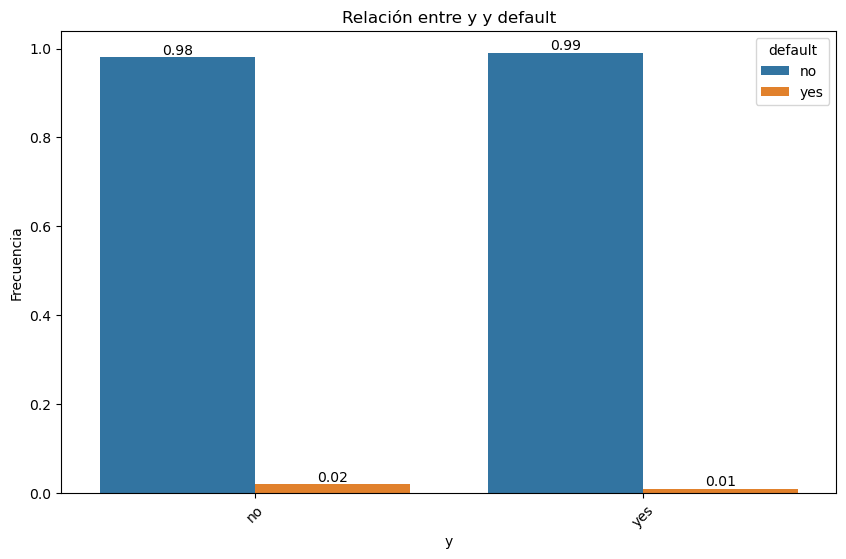

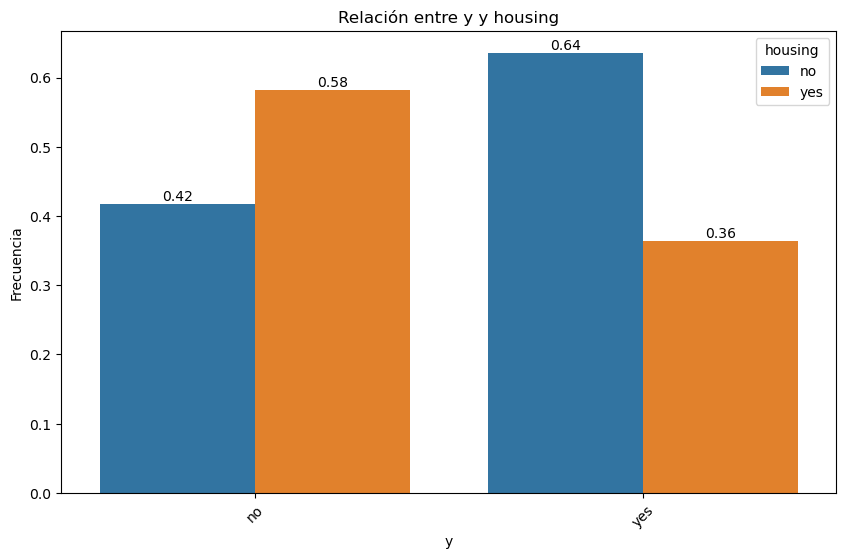

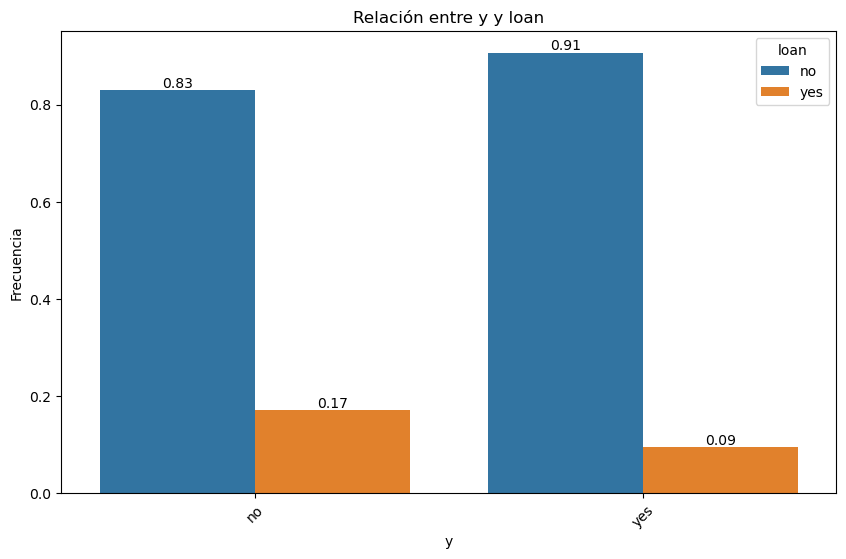

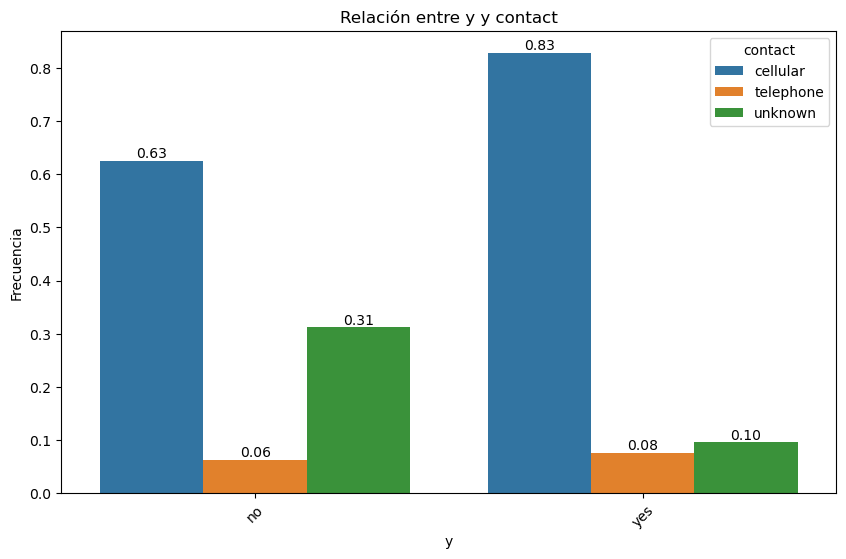

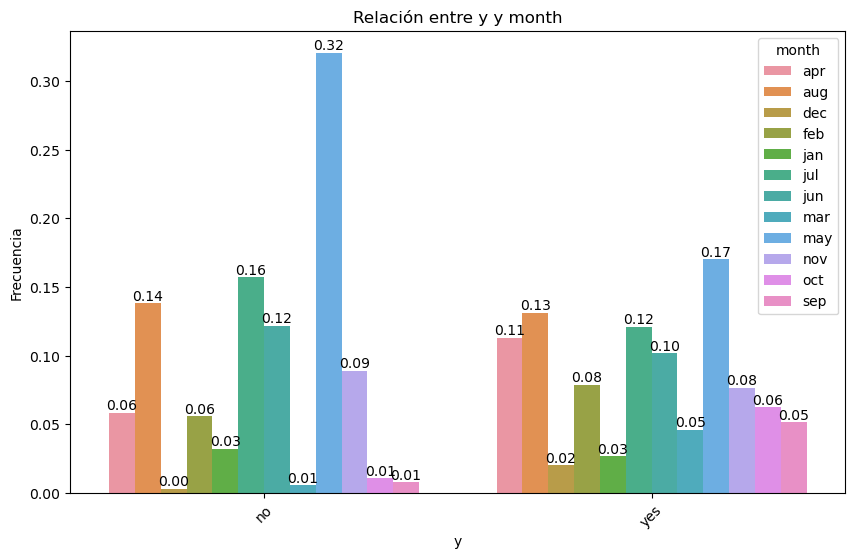

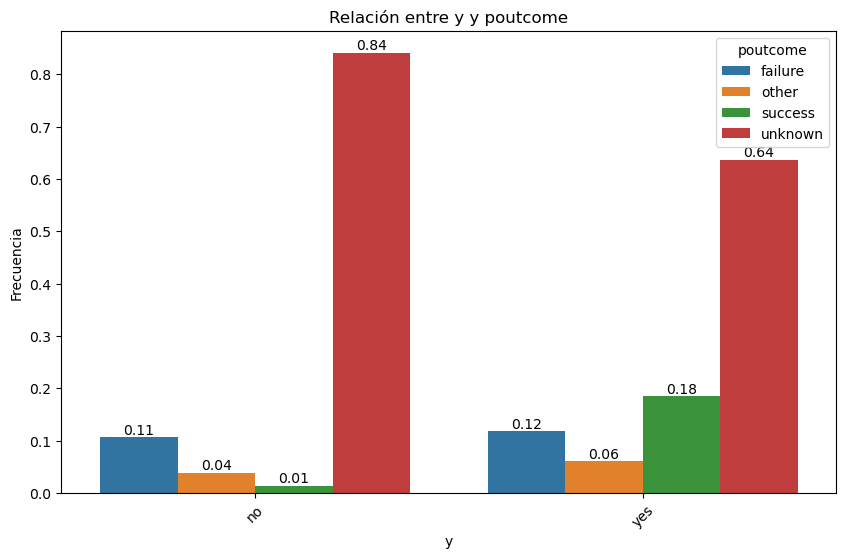

In [107]:
for col in categoricas:
    bt.plot_categorical_relationship_fin(train_set, target, col, relative_freq= True, show_values= True)

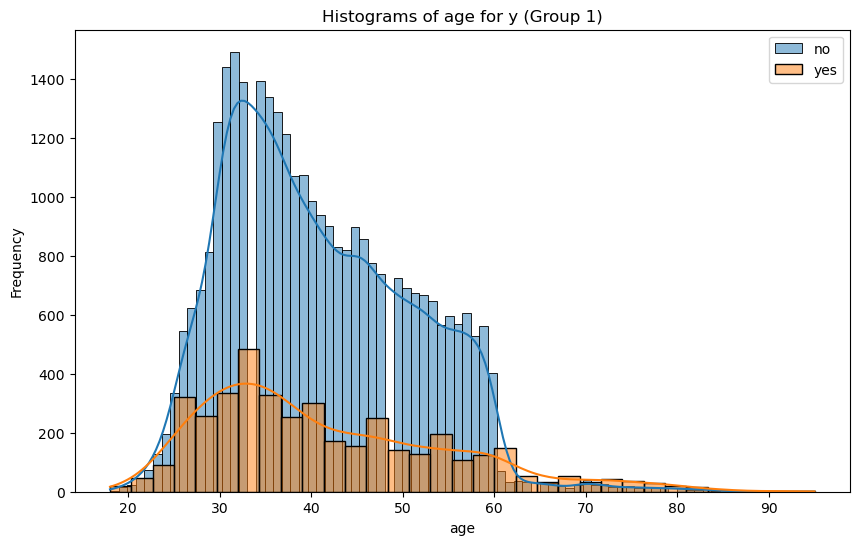

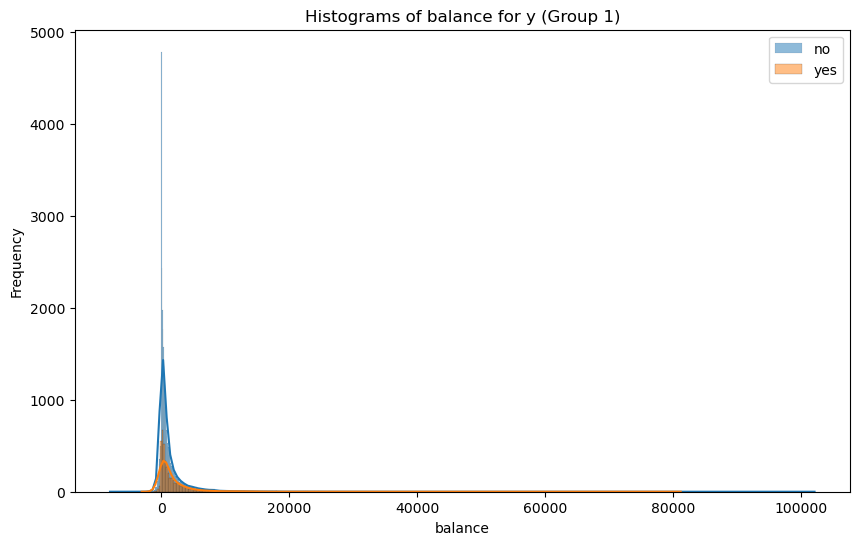

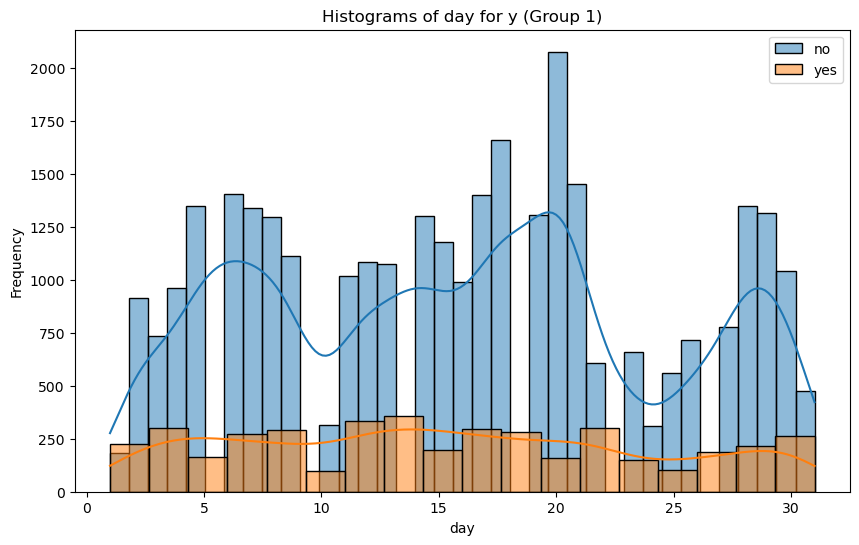

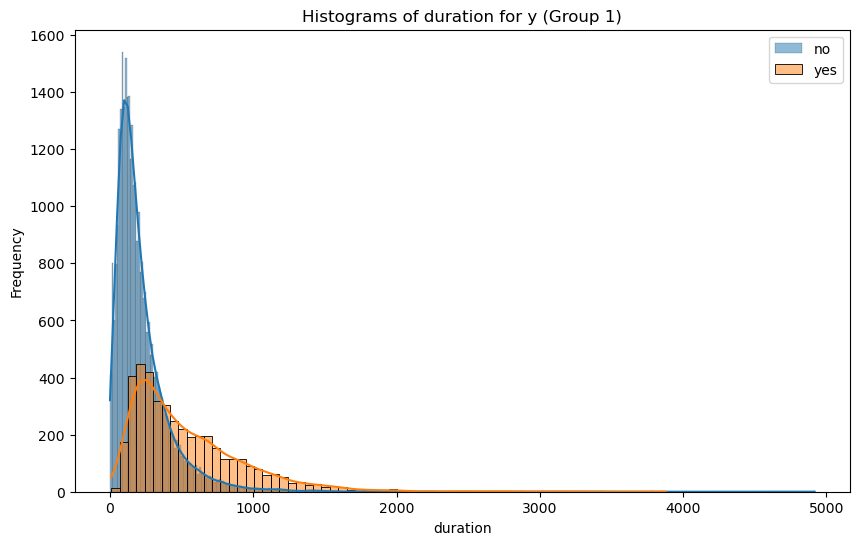

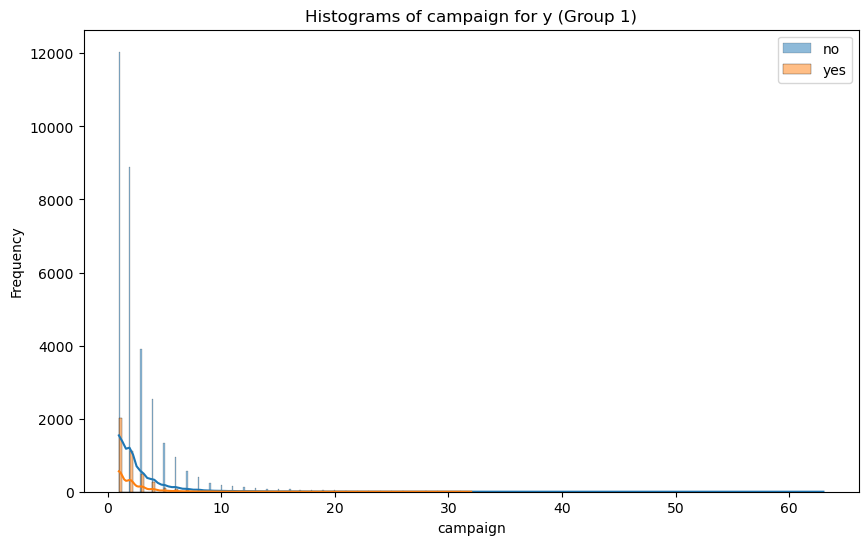

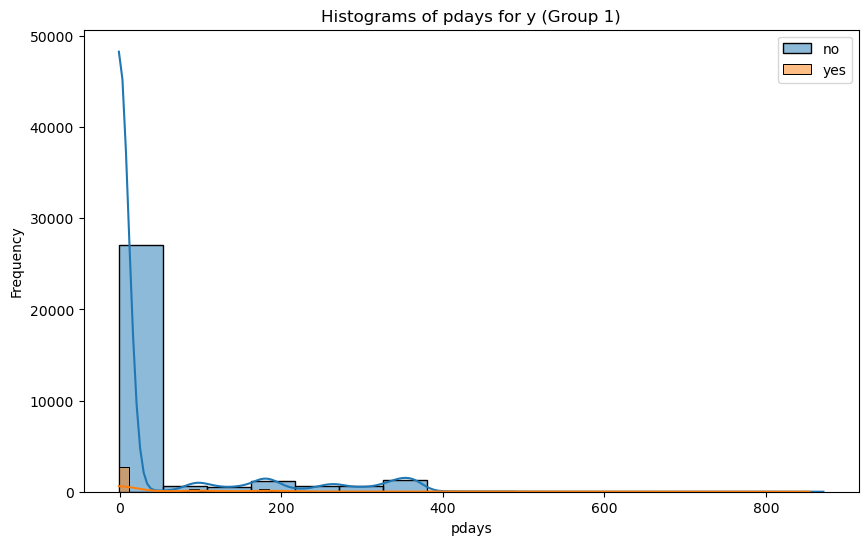

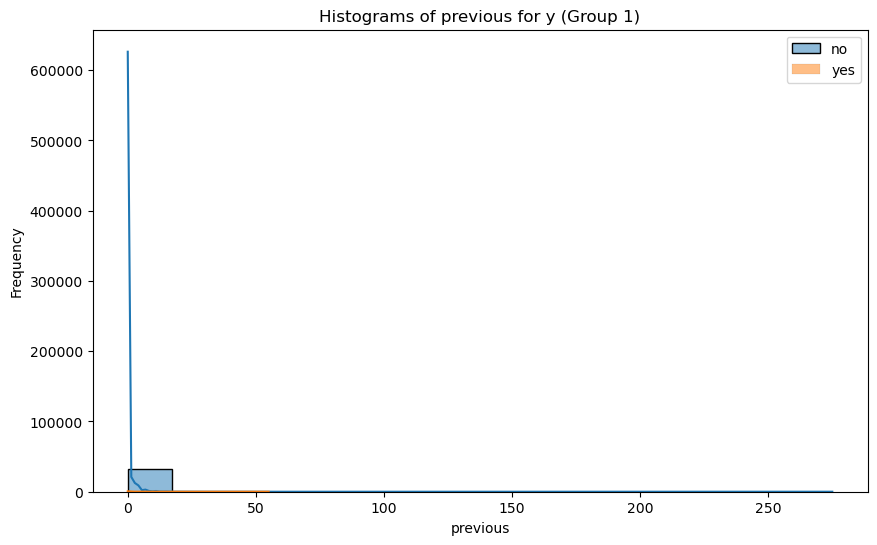

In [108]:
for col in numericas:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2)

In [109]:

train_set = pd.get_dummies(train_set, columns = categoricas, dtype = int)
test_set = pd.get_dummies(test_set, columns = categoricas, dtype = int)

In [110]:
x_train = train_set.drop(columns= ['y'])
y_train = train_set.y

x_test = test_set.drop(columns= ['y'])
y_test = test_set.y

In [111]:
forest = DecisionTreeClassifier(max_depth= 5, random_state= 42)

forest.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [112]:
y_pred = forest.predict(x_train)

print('Precision de acierto del train --> ', accuracy_score(y_train, y_pred))

Precision de acierto del train -->  0.9065748728157488


In [113]:
y_check = forest.predict(x_test)

print('Precision de acierto del train --> ', accuracy_score(y_test, y_check))

Precision de acierto del train -->  0.8972686055512551


In [114]:
cross_validation = cross_val_score(forest, x_train, y_train, cv= 15)

print('Precision de resultados cruzados --> ', cross_validation)
print('Precision media de resultados cruzados --> ', cross_validation.mean())

Precision de resultados cruzados -->  [0.89966833 0.90298507 0.89635158 0.90667773 0.90377437 0.90377437
 0.90087101 0.9033596  0.90128577 0.9033596  0.90170054 0.9033596
 0.90377437 0.90626296 0.89879718]
Precision media de resultados cruzados -->  0.9024001381176517


In [116]:
param_grid = {
    'min_samples_split': [i for i in range(200, 1001, 200)],
    'min_samples_leaf': [i for i in range(50, 1001, 50)],
    'max_depth': [i for i in range(1, 11)]
}

random_search = RandomizedSearchCV(forest, 
                                   param_grid, 
                                   random_state= 42,
                                   n_iter=100, 
                                   cv=5, # Folds del cross validation
                                   scoring="accuracy",
                                   n_jobs = -1 
                                  )

random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(max_depth=5,
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_samples_leaf': [50, 100, 150, 200,
                                                             250, 300, 350, 400,
                                                             450, 500, 550, 600,
                                                             650, 700, 750, 800,
                                                             850, 900, 950,
                                                             1000],
                                        'min_samples_split': [200, 400, 600,
                                                              800, 1000]},
                   random_state=42, scoring='accuracy')

In [117]:
random_search.best_params_

{'min_samples_split': 600, 'min_samples_leaf': 50, 'max_depth': 10}

In [118]:
forest_opt = DecisionTreeClassifier(min_samples_split=600, max_depth= 10, min_samples_leaf=50)

forest_opt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=600)

In [119]:
y_pred_opt = forest_opt.predict(x_train)

print('Precision de acierto del train --> ', accuracy_score(y_train, y_pred_opt))

Precision de acierto del train -->  0.9042800265428003


In [120]:
y_check_opt = forest_opt.predict(x_test)

print('Precision de acierto del train --> ', accuracy_score(y_test, y_check_opt))

Precision de acierto del train -->  0.8957204467543957


Pues tampoco es que nos haya mejorado, podría deberse a que falta realizar una mejor busqueda o que otras formas de clasificacion funcionan mejor